In [2]:
from collections import defaultdict as ddict
from copy import deepcopy as copy
import pickle
import matplotlib.pyplot as plt
import random
import os

import tensorflow as tf

from tensorflow import feature_column,keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Input, Dense,BatchNormalization
from tensorflow.python.keras.models import Model

import pandas as pd
import numpy as np
import seaborn as sns
from IPython.core.display import HTML
from IPython.display import SVG
#!source activate my-rdkit-env && python 
from rdkit import RDLogger
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Draw.rdMolDraw2D import MolDraw2DSVG
from rdkit.Chem.rdmolops import SanitizeFlags
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,MinMaxScaler
from sklearn.svm import SVR
from sklearn.cluster import KMeans
import sys
#import dill
import joblib
# Set the RDKit logging level to CRITICAL, because 
# lot of RDKit errors occur during the extraction of the 
# fragments. However, the corresponding molecules are 
# corrected in the further course.
RDLogger.logger().setLevel(RDLogger.CRITICAL)

# In many cases NaN
not_used_desc = ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge']

# Create a descriptor calculator for all RDKit descriptors except the ones above
desc_calc = MolecularDescriptorCalculator([x for x in [x[0] for x in Descriptors.descList] if x not in not_used_desc])

/home/nathaniel/anaconda3/envs/pyg/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nathaniel/anaconda3/envs/pyg/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nathaniel/anaconda3/envs/pyg/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nathaniel/anaconda3/envs/pyg/lib/python3

In [4]:
def show(df):
    return HTML(df.to_html(notebook=True))

In [5]:
#note only characters for the first 20 elements is included
#for organic molecules this should be sufficient

SMILES_CHARS = [
    ' ',
    '#', '%', '(', ')', '+', '-', '.', '/',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    '=', '@',
    'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
    'R', 'S', 'T', 'V', 'X', 'Z',
    '[', '\\', ']',
    'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
    't', 'u'
]

In [6]:
smi_enc_dict = dict( (ch, i) for i, ch in enumerate(SMILES_CHARS) )
smi_dec_dict = dict( (i, ch) for i, ch in enumerate(SMILES_CHARS)  )

In [7]:
def smiles_encoder(smiles, max_length=300):
    smi_mat = np.zeros((max_length, len(SMILES_CHARS)))
    for ID, char in enumerate(smiles):
        smi_mat[ID, smi_enc_dict[char]] = 1
    return smi_mat

def smiles_decoder(smi_mat):
    smi_str = ''
    smi_mat = smi_mat.argmax(axis=-1)
    for i in smi_mat:
        smi_str += smi_dec_dict[i]
    return smi_str


In [ ]:
# Preparring datasets by matching the dataset lengths (dataX will be the SMILES strings and dataY will be individual characters in the SMILE string)
# seq_length = 137

In [8]:
sdf_path = os.path.join(os.getcwd(), 'compounds.sdf')

In [9]:
dataset = PandasTools.LoadSDF(sdf_path)

,BROAD_CPD_ID,CPD_NAME,CPD_TYPE,CPD_SMILES,ID,ROMol
0,BRD-K59962020,BRD2020,BIO,Cc1cc2nc(NCCCO)n(CC(=O)c3cc(c(O)c(c3)C(C)(C)C)...,BRD2020,
1,BRD-K15888437,BRD-K15888437,BIO,CCc1cc2c(cc1OC(C)=O)oc(C)c(-c1nc3ccccc3n1C)c2=O,BRD-K15888437,
2,BRD-K19499941,BRD-K19499941,BIO,CCCCCCCN(C(=O)CCl)c1cccc(C)c1,BRD-K19499941,
3,BRD-K03704870,BRD-K03704870,BIO,CCc1ccc(OCC(=O)Nc2nnc[nH]2)cc1,BRD-K03704870,

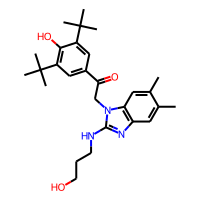
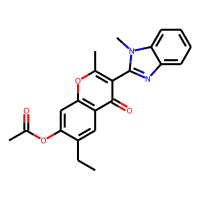
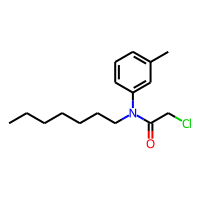
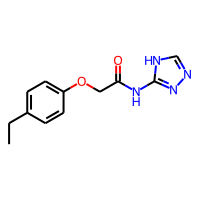

In [10]:
show(dataset.head(4))

In [20]:
smiles_train, smiles_test = train_test_split(dataset["CPD_SMILES"], random_state=20)

print(smiles_train.shape)
print(smiles_test.shape)

(24243,)
(8081,)


In [13]:
charset = set("".join(list(dataset.CPD_SMILES)) + "!E")

char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))

In [17]:
max_length = max([len(smile) for smile in dataset.CPD_SMILES]) + 5

In [18]:
print(str(charset))
print(len(charset), max_length)

{'@', 'c', '1', 'B', 'E', '\\', 'O', 'P', 'l', '5', 'r', '4', 'S', 'N', 'I', 'n', '!', 'H', 'C', 'F', ']', '6', '#', '2', 'o', '-', '+', '.', '/', 's', 'e', '7', '[', '3', '(', ')', '='}
37 230


In [22]:
def vectorise(smiles, charset, max_length=300):
        one_hot =  np.zeros((smiles.shape[0], max_length , len(charset)))
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [27]:
X_train, Y_train = vectorise(smiles_train.values, charset, max_length=max_length)
X_test, Y_test = vectorise(smiles_train.values, charset, max_length=max_length)


In [26]:
test_smi = X_train[0]

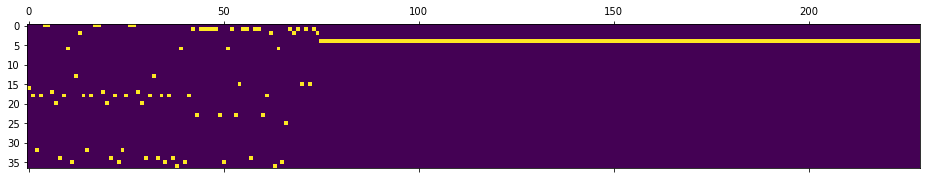

In [28]:
plt.matshow(X_train[0].T)

In [29]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Concatenate
from tensorflow.python.keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

In [ ]:
inputs = Input(shape=input_shape)
mol_generator = LSTM(lstm_dim, return_state=True)
outputs, state_h, state_c = mol_generator(inputs)